# This is Jeopardy!

#### Overview

This project is slightly different than others you have encountered thus far. Instead of a step-by-step tutorial, this project contains a series of open-ended requirements which describe the project you'll be building. There are many possible ways to correctly fulfill all of these requirements, and you should expect to use the internet, Codecademy, and/or other resources when you encounter a problem that you cannot easily solve.

#### Project Goals

You will work to write several functions that investigate a dataset of _Jeopardy!_ questions and answers. Filter the dataset for topics that you're interested in, compute the average difficulty of those questions, and train to become the next Jeopardy champion!

## Prerequisites

In order to complete this project, you should have completed the Pandas lessons in the <a href="https://www.codecademy.com/learn/paths/analyze-data-with-python">Analyze Data with Python Skill Path</a>. You can also find those lessons in the <a href="https://www.codecademy.com/learn/data-processing-pandas">Data Analysis with Pandas course</a> or the <a href="https://www.codecademy.com/learn/paths/data-science/">Data Scientist Career Path</a>.

Finally, the <a href="https://www.codecademy.com/learn/practical-data-cleaning">Practical Data Cleaning</a> course may also be helpful.

## Project Requirements

1. We've provided a csv file containing data about the game show _Jeopardy!_ in a file named `jeopardy.csv`. Load the data into a DataFrame and investigate its contents. Try to print out specific columns.

   Note that in order to make this project as "real-world" as possible, we haven't modified the data at all - we're giving it to you exactly how we found it. As a result, this data isn't as "clean" as the datasets you normally find on Codecademy. More specifically, there's something odd about the column names. After you figure out the problem with the column names, you may want to rename them to make your life easier for the rest of the project.
   
   In order to display the full contents of a column, we've added this line of code for you:
   
   ```py
   pd.set_option('display.max_colwidth', None)
   ```

**Import libraries and set display options. Read in the original csv.**

In [226]:
#Import libraries and set display options. Read in the original csv.
import pandas as pd
import re
from bs4 import BeautifulSoup, Tag, NavigableString
import numpy as np
import pprint
import textwrap
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
jeopardy = pd.read_csv("jeopardy.csv")

**Data cleaning:**
* Strip whitespace from beginning/end of column names, remove spaces between column name words, and make column names all lower case
* Make sure that all game rounds are lower case and without punctuation
* Check for null fields in dataframe & remove or repair
* Fix the two answers that are 'null'
* Check the categories column, make it lower case & remove/replace punctuation
* Find duplicated questions and remove duplicates
* Find all video/audio/image questions that don't have an associated file link and remove them
* Find all link based questions and create a new column for the links, then replace the links with link_text

*Creating a link column where there are more than two links requires a list in the dataframe column. This makes analysis difficult as lists are mutable and so PANDAS does not deal well with them during larger operations. There are several ways to handle this. One is by dropping the column from the dataframe during operations that would be impacted. This is what I've chosen to use, but it could be more useful to simply not retain the link data.*

In [227]:
#rename the columns with useable names - remove whitespace, use lower case, change round and value to non-reserved names
jeopardy = jeopardy.rename(columns = {'Show Number':'show_number', ' Air Date':'air_date', ' Round':'game_round', ' Category':'category', ' Value': 'dollar_value',' Question':'question', ' Answer':'answer'})

In [228]:
#Remove punctuation from game rounds
#print(jeopardy.game_round.unique())
jeopardy['game_round'] = jeopardy.game_round.apply(lambda x: x.replace('!', ''))
#print(jeopardy.game_round.unique())

In [229]:
#Categories - remove whitespace, create new column that's just the words from the category (for analysis) without punctuation, but replace '!' with 'exclamation mark [altered]'
#print(jeopardy.category.count())
#print(jeopardy.category.nunique())
jeopardy['category'] = jeopardy.category.apply(lambda x: x.strip())
jeopardy['category_words']= jeopardy['category']
jeopardy['category_words'] = jeopardy.category.apply(lambda x: x.lower())
exclaim_ind = jeopardy.index[jeopardy.category_words =='"!"'].to_list()
for idx in exclaim_ind:
    jeopardy.at[idx, 'category_words'] = "exclamation mark [altered]"

In [230]:
#Function to remove the special characters from a column and just let the words exist in a new column
def replace_in_column (column, **kwargs):
    for key, value in kwargs.items():
        altered_col = column.str.replace(key, value, regex = True)
    return altered_col
replace_punctuation = {'&': 'and','-':'\ ', '_*': '(blank)', '[^\w\s]':''}
jeopardy['category_words'] = replace_in_column(jeopardy['category_words'],**replace_punctuation)

In [231]:
#Function to create a link column from the links in text string in a new column
def link_finder (column):
       soup = BeautifulSoup(column, 'html.parser')
       links = soup.findAll('a', href = True)
       urls = []
       if links != []:
            for link in links:
                     url = link['href']
                     urls.append(url)
       else:
            urls.append("no link")
       urls = ", ".join(urls)
       return urls
jeopardy['link_url'] = jeopardy.question.apply(link_finder)


In [232]:
#Check for duplicate questions & filter to unique questions
#Remove lines containing filler questions,missing audio/video clues, There are several questions that contain [video clue], [audio clue], or [filler] with no link or data on the question, remove those
odd_questions = jeopardy[jeopardy.question.str.contains('\[')]
bad_questions = ['[audio clue]', '[video clue]', '[filler]']
filter_questions = jeopardy[jeopardy.question.isin(bad_questions)]
jeopardy = pd.concat([jeopardy, filter_questions]).drop_duplicates(keep = False)
# Drop any remaining duplicate questions
jeopardy = jeopardy.drop_duplicates('question')
duplicate_questions = jeopardy.question.duplicated().any()
#print(duplicate_questions)

In [233]:
#lambda to create a question column with no links or punctuation
jeopardy['question_no_link'] =jeopardy.question.apply(lambda text: BeautifulSoup(text, 'html.parser').get_text())


In [234]:
jeopardy['question_no_link'] = replace_in_column(jeopardy['question_no_link'], **replace_punctuation)
jeopardy['question_no_link'] = jeopardy.question_no_link.str.lower()

In [235]:
#The answer to two of the questions is 'null' so it got pulled in as a Null value. Let's see if we can fix that.
#Function to replace Null values with the word 'null' when appropriate
def null_value_fixer (df, column_name):
    column = df[column_name]
    indices = (df.index.values[column.isnull()])
    new_df = df.copy()
    for indx in indices:
        new_df.loc[indx, column_name] = '[null]'
    return new_df

jeopardy = null_value_fixer(jeopardy, 'answer')

In [236]:
#Clean answers by duplicating column to one with just the words & text, removing punctuation and making lower case 
jeopardy['answer_words'] = replace_in_column(jeopardy['answer'], **replace_punctuation)
jeopardy['answer_words'] = jeopardy.answer_words.str.lower()

In [237]:
#Remove punctuation from dollar_value
jeopardy['dollar_value'] = jeopardy.dollar_value.str.replace('(\D+)', '', regex= True)

In [238]:
#Create a csv of the cleaned data including the newly created columns and reset the jeopardy database to drop the links column for ease of use.
#jeopardy.to_csv("jeopardy_clean.csv")

In [239]:
jeopardy = jeopardy.copy().drop('link_url', axis = 1)

2. Write a function that filters the dataset for questions that contains all of the words in a list of words. For example, when the list `["King", "England"]` was passed to our function, the function returned a DataFrame of 49 rows. Every row had the strings `"King"` and `"England"` somewhere in its `" Question"`.

   Test your function by printing out the column containing the question of each row of the dataset.

**My initial answer to this section found words in an "or" list that did not fully answer the question. It would have found all the questions with the word "king" or the word "England" but would not found only the intersection.**

In [240]:
#Initial Answer: function to find words from a words list in a dataframe column, count them, and return dictionaris of the word:count, and the word:column-rows. 
def words_list_counter (column, words_list):
    wordlist_questions = {}
    word_list_count = {}
    for word in words_list:
        word = word.lower()
        count = column[column.str.contains(word)].count()
        word_questions = column[column.str.contains(word)].reset_index(drop=True)
        word_list_count[word]=count
        wordlist_questions [word] = word_questions
    return word_list_count, wordlist_questions


In [241]:
#Initial Answer: test the function to find questions about topics with terrains.
terrain_list = ["land","plain", "sea", "ocean"]
terrain_questions_count, terrain_questions = words_list_counter(jeopardy['question'], terrain_list)
print(terrain_questions_count)
#print(terrain_questions)

{'land': 8520, 'plain': 420, 'sea': 3844, 'ocean': 325}


**Second answer, noting the need for an answer that finds the intersection of lines that includes all words from the input list**


Input dataframe, column, words_list


Output: dataframe selecting only lines that include all words from the wordslist in the selected column

In [242]:
def word_list_overlap (df, column, words_list):
    df_subset = df.copy()
    for word in words_list:
        word = word.lower()
        df_subset = df_subset[df_subset[column].str.contains(word)].reset_index()
    return df_subset[column]

In [243]:
australia_island_list = ['australia', 'island']
australia_island_overlap_questions = word_list_overlap(jeopardy, 'question_no_link', australia_island_list)
print(australia_island_overlap_questions)

0                                             the islands in australias yampi sound are rich in hematite an ore of this metal
1                      the quokka a shorttailed species of this kangaroo relative is found on rottnest island  in w australia
2                         ten days on the island is an annual cultural festival taking place throughout this australian state
3                            the university of this island state boasts one of the southernmost college campuses in australia
4                         in november 1642 this dutchman discovered the island now named for him south of australias mainland
5                                                       the last pureblooded aborigine on this australian island died in 1876
6                                maori is an official language of this island country about 1000 miles southeast of australia
7             in 179899 george bass  matthew flinders proved this current australian state was an island by sailing ar

3. Test your original function with a few different sets of words to try to find some ways your function breaks. Edit your function so it is more robust.

   For example, think about capitalization. We probably want to find questions that contain the word `"King"` or `"king"`.
   
   You may also want to check to make sure you don't find rows that contain substrings of your given words. For example, our function found a question that didn't contain the word `"king"`, however it did contain the word `"viking"` &mdash; it found the `"king"` inside `"viking"`. Note that this also comes with some drawbacks &mdash; you would no longer find questions that contained words like `"England's"`.

In [244]:
#test the function to find questions about topics with terrains.
water_list = ['Ocean', 'Sea']
water_questions= word_list_overlap(jeopardy, 'question_no_link', water_list)
print(water_questions.count())
print(water_questions.values)

58
['a 35millionsquaremile land area between the atlantic ocean  the red sea'
 'counting crows in 1492 columbus sailed the ocean blue in ____ he came home across the deep blue sea'
 'genesis calls it the salt sea perhaps because its salinity reaches 4 times that of ocean water'
 'amsterdam island in the indian ocean 1800 mi from any cont has a rare type of this wandering seabird'
 'some say the weddell sea is an arm of the antarctic ocean others say its part of this larger ocean'
 'the persian gulf is an arm of the arabian sea which is part of this ocean'
 'its a portion of an ocean or sea partly enclosed by land theres one of aden'
 'oceanus hopkins was born on this ship while it was at sea peregrine white after it got to new england'
 'oceanus hopkins was born at sea in 1620 aboard this pilgrim ship'
 'when this spaniard reached the shore of the pacific ocean on september 29 1513 he called it the south sea'
 'cy tung bought this ocean liner in 1970 with plans to convert her into the 

*Breaks on 'researcher', 'oceanus', 'seasonal'.*

In [245]:
#test the function to find questions about topics with terrains.
king_england_list = ['King', 'England']
king_england_questions= word_list_overlap(jeopardy, 'question_no_link', king_england_list)
print(king_england_questions.count())
print(king_england_questions.values)

152
['both englands king george v  fdr put their stamp of approval on this king of hobbies'
 'in retaliation for viking raids this unready king of england attacks norse areas of the isle of man'
 'this king of england beat the odds to trounce the french in the 1415 battle of agincourt'
 'this scotsman the first stuart king of england was called the wisest fool in christendom'
 'its the number that followed the last king of england named william'
 'nelson said england expects that every man will do this  died thanking god he did his'
 'this countrys king louis iv was nicknamed louis from overseas because he was raised in england'
 'there was good kinging in the 800sleo the wise ruled the byzantine empire while england had alfred the this'
 'in 1199 this crusader king of england was mortally wounded while besieging the castle of chalus'
 'name of 8 kings of england since 1272 it was also general lees middle name'
 'he was the only king of england to have the great tacked on to his name'


*Breaks on 'viking', 'thanking'.*

**I'll want to limit words that include an input word, while allowing for plurals.**

In [274]:
def word_list_overlap_v2 (df, column, words_list):
    df_subset = df.copy()
    for word in words_list:
        word = word.lower()
        regex_word = "(?:(^|\s)+"+word+"+(\s|((s|es)+($|\s))))"
        df_subset = df_subset[df_subset[column].str.contains(regex_word, regex= True)].reset_index()
    return df_subset

In [275]:
#test the function to find questions about topics with queen, england
queen_england_list = ['Queen', 'England']
queen_england_questions_1= word_list_overlap_v2(jeopardy, 'question_no_link', queen_england_list)
print(queen_england_questions_1.question.count())
print(queen_england_questions_1["question"].values)

/tmp/ipykernel_731028/2291917690.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_subset = df_subset[df_subset[column].str.contains(regex_word, regex= True)].reset_index()


36
['In 1707 her title changed to Queen of Great Britain & Ireland (it used to be Queen of England, Scotland & Ireland)'
 "In 1632 this court painter to England's Charles I & Queen Henrietta Maria was knighted"
 "The queen of England probably didn't use the dart in the map trick to make this city a capital in 1857"
 'This Queen of England was the granddaughter of Ferdinand & Isabella of Spain'
 "In England the anniversary of this queen's birthday is observed on a Saturday following May 24"
 'England\'s "Good Queen Bess"'
 'In 1706 she was queen of England & involved in a North American war bearing her name'
 'She was the queen of England from 1558 to 1603'
 "A true 9 days' wonder, her reign as Queen of England was for a mere 9 days in July of 1553"
 'On July 10, 1553 this unfortunate lady was proclaimed queen of England, succeeding Edward VI'
 'This granddaughter of George III became queen of England in 1837'
 "When England's Queen Anne died, this German became king because he was a gr

/tmp/ipykernel_731028/2291917690.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_subset = df_subset[df_subset[column].str.contains(regex_word, regex= True)].reset_index()


*This is improved, the regex catches plurals, but not topic word inclusions in other words (ie - sea in researcher)*

4. We may want to eventually compute aggregate statistics, like `.mean()` on the `" Value"` column. But right now, the values in that column are strings. Convert the`" Value"` column to floats. If you'd like to, you can create a new column with float values.

   Now that you can filter the dataset of question, use your new column that contains the float values of each question to find the "difficulty" of certain topics. For example, what is the average value of questions that contain the word `"King"`?
   
   Make sure to use the dataset that contains the float values as the dataset you use in your filtering function.

In [248]:
#convert all the final jeopardy questions to a value of 0 so that I can convert the value column to float
final_jeopardy_no_val = jeopardy[jeopardy['dollar_value']=='']
no_val_indx = (jeopardy.index.values[jeopardy['dollar_value']==''])
jeopardy_temp = jeopardy.copy()
for indx in no_val_indx:
    jeopardy_temp.loc[indx, 'dollar_value'] = 0
jeopardy['dollar_value_flt'] = jeopardy_temp['dollar_value'].astype(float)

*Note: Average values that aren't limited to non-zero dolar_value_ft rows are inaccurate.Converting to Final jeopardy rounds are not really zero values*

Average values for questions:

In [249]:
# average value of questions by jeopardy round - Tiebreaker and Final Jeopardy rounds do not have values listed
avg_round_value = lambda x: x[x['game_round'].isin(['Double Jeopardy', 'Jeopardy'])].groupby('game_round').dollar_value_flt.mean().round(2)
print(avg_round_value(jeopardy))

game_round
Double Jeopardy    1017.47
Jeopardy            491.78
Name: dollar_value_flt, dtype: float64


The average value of questions containing the word 'king': 

In [285]:
king_lst = ['king']
king_que= word_list_overlap_v2(jeopardy, 'question_no_link', king_lst)
avg_king_round = avg_round_value(king_que)
pprint.pprint(avg_king_round)


/tmp/ipykernel_731028/2291917690.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_subset = df_subset[df_subset[column].str.contains(regex_word, regex= True)].reset_index()


game_round
Double Jeopardy    1032.37
Jeopardy            525.23
Name: dollar_value_flt, dtype: float64


5. Write a function that returns the count of unique answers to all of the questions in a dataset. For example, after filtering the entire dataset to only questions containing the word `"King"`, we could then find all of the unique answers to those questions. The answer "Henry VIII" appeared 55 times and was the most common answer.

In [250]:
def unique_high_freq_answers (df,answers_column, frequency_threshold):
    answers_counts = pd.DataFrame(df[answers_column].value_counts())
    answers_counts.reset_index(inplace=True)
    answers_counts = answers_counts.rename(columns={'index': 'answer', 'answer_words': 'answer_freq'})
    high_freq_ans = answers_counts[answers_counts['answer_freq']>= frequency_threshold]
    return high_freq_ans

In [251]:
jeopardy_unique_answers = (unique_high_freq_answers(jeopardy, 'answer_words', 150))
print(jeopardy_unique_answers)

        answer  answer_freq
0    australia          213
1        china          213
2        japan          194
3      chicago          194
4       france          189
5        india          185
6   california          179
7       canada          173
8        spain          168
9       mexico          163
10      alaska          160
11       italy          159
12      hawaii          157
13       texas          152


In [253]:
class String_in_column_freq:
    df = jeopardy.copy()

    def __init__(self,  filter_column, target_column, topic_strings, freq_threshold) -> None:
        self.filter_name = filter_column
        self.target_name = target_column
        self.column = String_in_column_freq.df[target_column]
        self.filter = String_in_column_freq.df[filter_column]
        self.topics = topic_strings
        self.freq_threshold = freq_threshold
        self.filter_column_inc_topic = {}
        self.filter_column_topic_count = {}
        self.target_topic_above_freq_threshold = {}
    
    def show(self):
        topics_as_string = ", ".join(map(str, self.topics))
        print('Within the jeopardy dataframe we are looking at the frequency with which strings occur in a column')
        print('This class allows us to find all rows of the dataframe where we values frome a list of topics ('+ topics_as_string + ') in the filter column of: ' + self.filter_name)
        print('It then counts the frequency of values in '+ self.target_name+ ' that occur more frequently than the threshold value of ' + str(self.freq_threshold))
        print('The target column is: '+ self.target_name)
        print('The strings are: '+ topics_as_string)
        print('The filter column is: '+ self.filter_name)
        print('The frequency threshold for target column values is: '+ str(self.freq_threshold))
        print('To access the frequency with which our topics show up in the filter column, call topic filter and access self.filter_column topic count')
        print('To access the frequency of values in the target column associated with the filter topics, call high_frequency_targets and access self.target_topic_above_freq_threshold')

    def topic_filter(self):
        for topic in self.topics:
            topic = topic.lower()
            #in case topic is one word that can be part of compound words, this regex will limit it to just the word
            regex_topic = ('\W'+topic+'\W')
            #topic_in_filter = String_in_column_freq.df[self.filter.str.contains(regex_topic, regex=True)]
            topic_in_filter = String_in_column_freq.df[self.filter.str.contains(regex_topic, regex=True)]
            self.filter_column_inc_topic [topic] = topic_in_filter
            self.filter_column_topic_count [topic] = topic_in_filter[self.filter_name].count()
        return self.filter_column_inc_topic, self.filter_column_topic_count
    
    def high_frequency_targets (self):
        for key, value in self.filter_column_inc_topic.items():
            target_counts = pd.DataFrame(value[self.target_name].value_counts())
            target_counts.reset_index(inplace=True)
            target_counts = target_counts.rename(columns={'index': 'target', self.target_name: 'target_freq'})
            target_count_above_freq_threshold = target_counts[target_counts['target_freq']>=self.freq_threshold]
            self.target_topic_above_freq_threshold[key] = target_count_above_freq_threshold
    
    def topic_freq_report (self):
        print()

In [254]:
jeopardy_royalty_topics = ['King', 'Queen']
royalty = String_in_column_freq(filter_column='question_no_link',
                                target_column= 'answer_words', 
                                topic_strings=jeopardy_royalty_topics,
                                freq_threshold= 10)
#print(royalty.df.head(10))
#print(royalty.topics)
royalty.topic_filter()
print(royalty.show())
royalty.high_frequency_targets()
print(royalty.target_topic_above_freq_threshold)


Within the jeopardy dataframe we are looking at the frequency with which strings occur in a column
This class allows us to find all rows of the dataframe where we values frome a list of topics (King, Queen) in the filter column of: question_no_link
It then counts the frequency of values in answer_words that occur more frequently than the threshold value of 10
The target column is: answer_words
The strings are: King, Queen
The filter column is: question_no_link
The frequency threshold for target column values is: 10
To access the frequency with which our topics show up in the filter column, call topic filter and access self.filter_column topic count
To access the frequency of values in the target column associated with the filter topics, call high_frequency_targets and access self.target_topic_above_freq_threshold
None
{'king':                      target  target_freq
0                henry viii           35
1               richard iii           23
2                   solomon           

In [255]:
royalty.freq_threshold =5

In [256]:
royalty.topic_filter()
print(royalty.show())
royalty.high_frequency_targets()
print(royalty.target_topic_above_freq_threshold)

Within the jeopardy dataframe we are looking at the frequency with which strings occur in a column
This class allows us to find all rows of the dataframe where we values frome a list of topics (King, Queen) in the filter column of: question_no_link
It then counts the frequency of values in answer_words that occur more frequently than the threshold value of 5
The target column is: answer_words
The strings are: King, Queen
The filter column is: question_no_link
The frequency threshold for target column values is: 5
To access the frequency with which our topics show up in the filter column, call topic filter and access self.filter_column topic count
To access the frequency of values in the target column associated with the filter topics, call high_frequency_targets and access self.target_topic_above_freq_threshold
None
{'king':                      target  target_freq
0                henry viii           35
1               richard iii           23
2                   solomon           21

6. Explore from here! This is an incredibly rich dataset, and there are so many interesting things to discover. There are a few columns that we haven't even started looking at yet. Here are some ideas on ways to continue working with this data:

 * Investigate the ways in which questions change over time by filtering by the date. How many questions from the 90s use the word `"Computer"` compared to questions from the 2000s?
 * Is there a connection between the round and the category? Are you more likely to find certain categories, like `"Literature"` in Single Jeopardy or Double Jeopardy?
 * Build a system to quiz yourself. Grab random questions, and use the <a href="https://docs.python.org/3/library/functions.html#input">input</a> function to get a response from the user. Check to see if that response was right or wrong.

Exploratory question: How many unique categories are there? Which categories have the highest question counts? Which categories are more likely to be found in each round of jeopardy?

In [258]:
class Column_grouping_analysis:
    df = jeopardy.copy()

    def __init__(self, column_to_group) -> None:
        self.column_to_group = column_to_group
        self.group_column = Column_grouping_analysis.df[self.column_to_group]
        self.unique_in_group = self.unique_groups()
        self.group_counts = self.unique_group_item_count()
        self.high_freq_group_counts = self.high_freq_groups()
        self.high_freq_group_values = self.high_freq_groups_list()
        self.group_df_dict = self.hf_group_dataframe_subsets()
        self.secondary = ''

    def unique_groups (self):
        unique_cat_count = self.group_column.nunique()
        return unique_cat_count

    def unique_group_item_count (self):
        group_counts = pd.DataFrame(self.group_column.value_counts())
        group_counts.reset_index(inplace=True)
        group_counts = group_counts.rename(columns={'index': self.column_to_group, self.column_to_group: str(self.column_to_group+'_freq')})
        return group_counts
    
    def high_freq_groups (self, desired_num_groups = 10):
        high_freq_groups_item_count = self.group_counts.head(desired_num_groups)
        return high_freq_groups_item_count
    
    def high_freq_groups_list (self):
        list_high_freq_groups = self.high_freq_group_counts[self.column_to_group].tolist()
        return list_high_freq_groups
    
    def hf_group_dataframe_subsets (self):
        group_dataframe_subsets_dict = {}
        for value in self.high_freq_group_values:
            value_sub_df = Column_grouping_analysis.df[Column_grouping_analysis.df[self.column_to_group]==value]
            group_dataframe_subsets_dict[value] = value_sub_df
        return group_dataframe_subsets_dict
    
    def secondary_analysis_column_groups (self, secondary_column):
        self.secondary = secondary_column
        secondary_analysis_groups = []
        for key, value in self.group_df_dict.items():
            unique_secondary = pd.DataFrame(value[secondary_column].value_counts())
            unique_secondary.reset_index(inplace = True)
            unique_secondary = unique_secondary.rename(columns = {"index": secondary_column, secondary_column: str(secondary_column+'_count')})
            unique_secondary['group_column_hf_value'] = key
            secondary_analysis_groups.append(unique_secondary)
        secondary_analysis_df = pd.concat(secondary_analysis_groups, ignore_index=True)
        secondary_analysis_df_pivot = secondary_analysis_df.pivot(columns= secondary_column, index = 'group_column_hf_value', values=str(secondary_column+'_count'))
        return secondary_analysis_df_pivot
    
    def report (self, secondary_column):
        pivot = self.secondary_analysis_column_groups(secondary_column=secondary_column)
        print(textwrap.fill('''Within the Jeopardy dataset there are {n} unique values of {group_column} column.The {m} most frequent of these are listed in the following table along with their count.'''.format(n = self.unique_in_group, group_column = self.column_to_group, m = len(self.high_freq_group_values)), width = 80))
        pprint.pprint( self.high_freq_group_counts)
        print(textwrap.fill("""By cross comparing them with the values of {secondary_column} column we can utilize a pivot table to see a break down of the count of {group_column} broken down by the values of {secondary_column}.""".format(group_column = self.column_to_group, secondary_column = self.secondary), width = 80))
        pprint.pprint(pivot)


            


In [259]:
jeopardy_categories = Column_grouping_analysis('category_words')
jeopardy_categories.report('game_round')

Within the Jeopardy dataset there are 27155 unique values of category_words
column.The 10 most frequent of these are listed in the following table along
with their count.
           category_words  category_words_freq
0           before  after                  556
1                 science                  547
2              literature                  499
3        american history                  415
4               potpourri                  409
5           world history                  381
6            word origins                  368
7  colleges  universities                  354
8                 history                  349
9                  sports                  346
By cross comparing them with the values of game_round column we can utilize a
pivot table to see a break down of the count of category_words broken down by
the values of game_round.
game_round              Double Jeopardy  Final Jeopardy  Jeopardy
group_column_hf_value                                           

Exploratory question: What tech related questions, answers, and categories are there? Given a list of topic words, what are the concept related questions & answers? How have they changed over time?

In [260]:
class Topics_over_time:

    def __init__(self, df, filter_columns_list, filter_list, time_date_col, topic_descriptor ) -> None:
        self.df = df
        self.filter_columns = filter_columns_list
        self.topics = filter_list
        self.filtered_df_by_topic = self.filter_column_on_list()
        self.filtered_columns_by_topic = self.df_filtered_columns()
        self.df_item_count_by_topic = self.topic_item_count()
        self.date_col_name = time_date_col
        self.date_col = df[time_date_col]
        self.topic_count_by_year = self.topic_item_count_by_year()
        self.topic_descriptor = topic_descriptor
        self.topics_time_graph = self.graph_of_topic_by_time()
        pass
    
    def filter_column_on_list (self):
        dict_topics_df_lines = {}
        for item in self.topics:
            temp_df_list = []
            for col in self.filter_columns:
                temp_df = self.df[self.df[col].str.contains(item)]
                temp_df_list.append(temp_df)
            all_topic_lines_df = pd.concat(temp_df_list).reset_index(allow_duplicates=False)
            all_topic_lines_df.drop_duplicates(inplace= True)
            dict_topics_df_lines[item] = all_topic_lines_df   
        return dict_topics_df_lines
    
    def df_filtered_columns (self):
        dict_topic_df_filter_col = {}
        for key, value in self.filtered_df_by_topic.items():
            new_temp_df = value[self.filter_columns]
            dict_topic_df_filter_col[key] = new_temp_df
        return dict_topic_df_filter_col
    
    def topic_item_count (self):
        item_count_by_topic = {}
        for key, value in self.filtered_df_by_topic.items():
            item_count_by_topic[key] = (value['index'].count())
        return item_count_by_topic
    
    def topic_item_count_by_year (self):
        topic_item_count_yearly = []
        for key, value in self.filtered_df_by_topic.items():
            value[self.date_col_name] = pd.to_datetime(value[self.date_col_name])
            topic_item_by_year = value.groupby(value[self.date_col_name].dt.year).index.count()
            yearly_topic_counts = topic_item_by_year.reset_index()
            yearly_topic_counts.rename(columns = {'index':'item_count'}, inplace = True)
            yearly_topic_counts ['topic'] = key
            topic_item_count_yearly.append(yearly_topic_counts)
        yearly_topic_count_df= pd.concat(topic_item_count_yearly, ignore_index=True)
        yearly_topic_count_df_pivot = yearly_topic_count_df.pivot(columns= 'topic', index = self.date_col_name, values=str('item_count'))
        return yearly_topic_count_df_pivot
    
    def graph_of_topic_by_time(self):
        plt.plot(self.topic_count_by_year, label = self.topic_count_by_year.columns)
        plt.legend()
        plt.title(self.topic_descriptor)
        topics_over_time_graph = plt.show()
        return topics_over_time_graph

In [261]:
tech_words = ['internet', 'computer', 'digital', 'software','computing', 'coding','cyber', 'software', 'hardware']
topic_columns = ['category_words', 'question_no_link', 'answer_words']

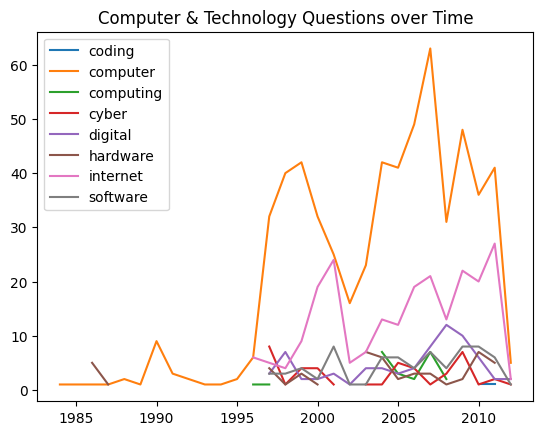

In [262]:
tech_over_time = Topics_over_time(
    df = jeopardy.copy(),
    filter_columns_list = topic_columns, 
    filter_list = tech_words,
    time_date_col = 'air_date',
    topic_descriptor = "Computer & Technology Questions over Time"
    )

In [263]:
freq_unique_ans = ['australia', 'china', 'japan']

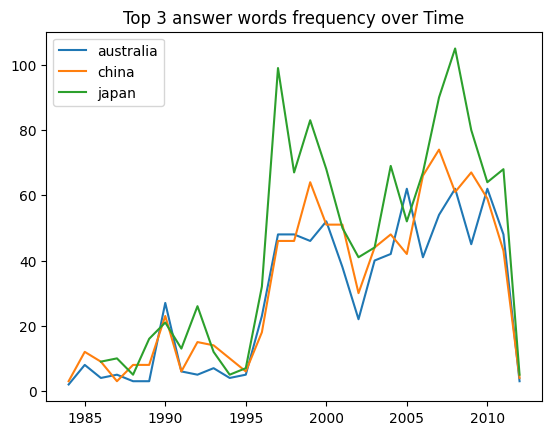

In [264]:
freq_unique_ans_over_time = Topics_over_time(
    df = jeopardy.copy(),
    filter_columns_list = topic_columns, 
    filter_list = freq_unique_ans,
    time_date_col = 'air_date',
    topic_descriptor = "Top 3 answer words frequency over Time"
    )

## Solution

7. Compare your program to our <a href="https://content.codecademy.com/PRO/independent-practice-projects/jeopardy/jeopardy_solution.zip">sample solution code</a> - remember, that your program might look different from ours (and probably will) and that's okay!

8. Great work! Visit <a href="https://discuss.codecademy.com/t/this-is-jeopardy-challenge-project-python-pandas/462365">our forums</a> to compare your project to our sample solution code. You can also learn how to host your own solution on GitHub so you can share it with other learners! Your solution might look different from ours, and that's okay! There are multiple ways to solve these projects, and you'll learn more by seeing others' code.